# ES-RNN model 

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement an ES-RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses recent values of load as the model input. The model will be trained to output a vector, the elements of which are ordered predictions for future time steps.
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [30]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict, deque
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

Load data into Pandas dataframe

In [31]:
energy = load_data('data/')
energy.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [32]:
energy.tail()

,load,temp
2014-12-31 19:00:00,"4,012.00",18.00
2014-12-31 20:00:00,"3,856.00",16.67
2014-12-31 21:00:00,"3,671.00",17.00
2014-12-31 22:00:00,"3,499.00",15.33
2014-12-31 23:00:00,"3,345.00",15.33


In [33]:
valid_start_dt = '2014-08-30 08:00:00'
test_start_dt = '2014-10-31 11:00:00'
test_end_dt = '2014-12-30 18:00:00'

T = 6
HORIZON = 3

In [34]:
train = energy.copy()[energy.index < valid_start_dt][['load']]

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train[['load']])
train[['load']] = scaler.transform(train)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [36]:
tensor_structure = {'X':(range(-T+1, 1), ['load'])}
train_inputs = TimeSeriesTensor(train, 'load', HORIZON, tensor_structure)

In [37]:
train_inputs.dataframe.head(3)

tensor              target              X                         
feature                  y           load                         
time step              t+1  t+2  t+3  t-5  t-4  t-3  t-2  t-1    t
2012-01-01 05:00:00   0.18 0.23 0.29 0.22 0.18 0.14 0.13 0.13 0.15
2012-01-01 06:00:00   0.23 0.29 0.35 0.18 0.14 0.13 0.13 0.15 0.18
2012-01-01 07:00:00   0.29 0.35 0.37 0.14 0.13 0.13 0.15 0.18 0.23

In [38]:
train_inputs.dataframe.shape

(23328, 9)

In [39]:
train_inputs['X'].shape

(23328, 6, 1)

In [40]:
train_inputs['X'][:3]

array([[[0.22],
        [0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15]],

       [[0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18]],

       [[0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18],
        [0.23]]])

In [41]:
train_inputs['target'][:3]

array([[0.18, 0.23, 0.29],
       [0.23, 0.29, 0.35],
       [0.29, 0.35, 0.37]])

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [42]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load']]
valid[['load']] = scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, 'load', HORIZON, tensor_structure)

## Implement ES-RNN

We will implement ES-RNN forecasting model with the following structure:

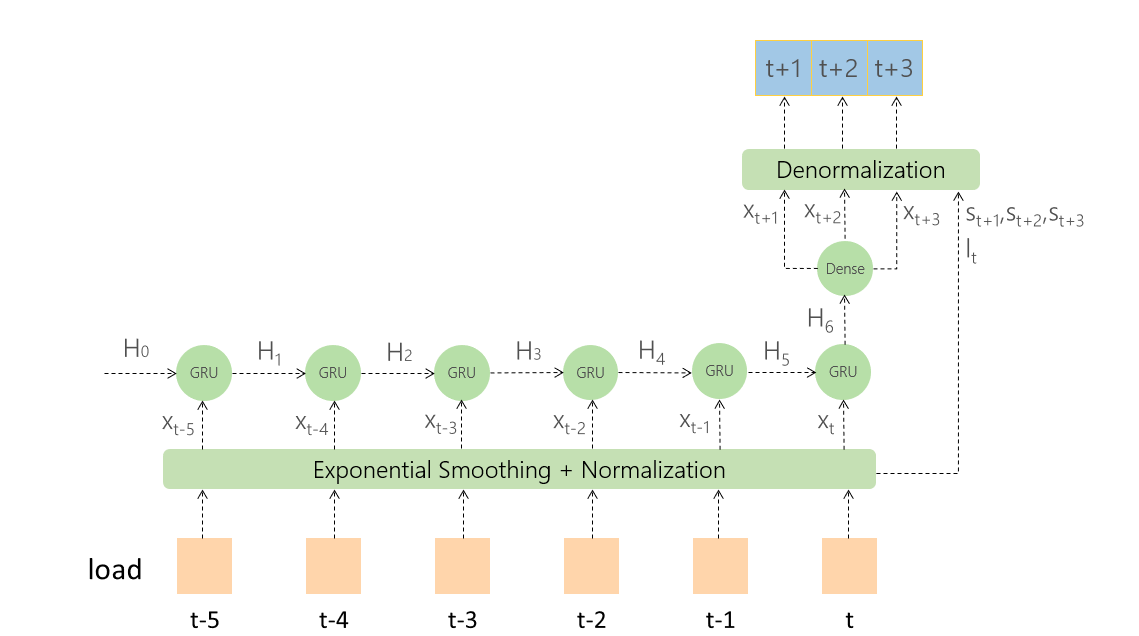

In [59]:
Image('./images/es_rnn.png')

In [44]:
from keras.models import Model
from keras.layers import Input, GRU, Dense, Lambda
from keras.callbacks import EarlyStopping

In [45]:
LATENT_DIM = 5
BATCH_SIZE = 48
EPOCHS = 1000
m = 24

In the next cell we define custom "Exponential Smoothing+Normalization" and "Denormalization" layers

In [46]:
from keras import backend as K
from keras.layers import Layer

# Exponential Smoothing + Normalization
class ES(Layer):

    def __init__(self, horizon, m, batch_size, time_steps, **kwargs):
        self.horizon = horizon
        self.m = m
        self.batch_size = batch_size
        self.time_steps = time_steps
        
        super(ES, self).__init__(**kwargs)

    # initialization of the learned parameters of exponential smoothing
    def build(self, input_shape):
        self.alpha = self.add_weight(name='alpha', shape=(1,),
                                     initializer='uniform', trainable=True)
        self.gamma = self.add_weight(name='gamma', shape=(1,),
                                     initializer='uniform', trainable=True)
        self.init_seasonality = self.add_weight(name='init_seasonality', shape=(self.m,),
                                                initializer='uniform', trainable=True)
        self.init_seasonality_list = [K.slice(self.init_seasonality,(i,),(1,)) for i in range(self.m)]
        self.seasonality_queue = deque(self.init_seasonality_list, self.m)
        self.level = K.zeros((1,))
        
        super(ES, self).build(input_shape)  

    def call(self, x):

        # extract time-series from feature vector
        n_examples = K.int_shape(x)[0]
        if n_examples is None:
            n_examples = self.batch_size
        x1 = K.slice(x,(0,0,0),(1,self.time_steps,1))
        x1 = K.reshape(x1,(self.time_steps,))
        x2 = K.slice(x,(1,self.time_steps-1,0),(n_examples-1,1,1))
        x2 = K.reshape(x2,(n_examples-1,))
        ts = K.concatenate([x1,x2])
        
        x_norm = []  # normalized values of time-series
        ls = []      # coeffients for denormalization of forecasts
        
        l_t_minus_1 = self.level
        
        for i in range(n_examples+self.time_steps-1):
        
            # compute l_t
            y_t = ts[i]
            s_t = self.seasonality_queue.popleft()
            l_t = self.alpha * y_t / s_t + (1 - self.alpha) * l_t_minus_1
            
            # compute s_{t+m}
            s_t_plus_m = self.gamma * y_t / l_t + (1 - self.gamma) * s_t
            
            self.seasonality_queue.append(s_t_plus_m)
            
            # normalize y_t
            x_norm.append(y_t / (s_t * l_t))

            l_t_minus_1 = l_t

            if i >= self.time_steps-1:
                l = [l_t]*self.horizon
                l = K.concatenate(l)
                s = [self.seasonality_queue[i] for i in range(self.horizon)] # we assume here that horizon < m
                s = K.concatenate(s)
                ls_t = K.concatenate([K.expand_dims(l), K.expand_dims(s)])
                ls.append(K.expand_dims(ls_t,axis=0))  
       
        self.level = l_t
        x_norm = K.concatenate(x_norm)

        # create x_out
        x_out = []
        for i in range(n_examples):
            norm_features = K.slice(x_norm,(i,),(self.time_steps,))
            norm_features = K.expand_dims(norm_features,axis=0)
            x_out.append(norm_features)

        x_out = K.concatenate(x_out, axis=0)
        x_out = K.expand_dims(x_out)

        # create tensor of denormalization coefficients 
        denorm_coeff = K.concatenate(ls, axis=0)
        return [x_out, denorm_coeff]

    def compute_output_shape(self, input_shape):
        return [(input_shape[0], input_shape[1], input_shape[2]), (input_shape[0], self.horizon, 2)]
    
class Denormalization(Layer):
    
    def __init__(self, **kwargs):
        super(Denormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Denormalization, self).build(input_shape)  

    def call(self, x):
        return x[0] * x[1][:,:,0] * x[1][:,:,1]

    def compute_output_shape(self, input_shape):
        return input_shape[0]

Since Denormalization layer has inputs from two previous layers, we need to use functional API of Keras

In [47]:
model_input = Input(shape=(None, 1))
[normalized_input, denormalization_coeff] = ES(HORIZON, m, BATCH_SIZE, T)(model_input)
gru_out = GRU(LATENT_DIM)(normalized_input)
model_output_normalized = Dense(HORIZON)(gru_out)
model_output = Denormalization()([model_output_normalized, denormalization_coeff])
model = Model(inputs=model_input, outputs=model_output)

In [48]:
model.compile(optimizer='RMSprop', loss='mse')

In [49]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
es_2 (ES)                       [(None, None, 1), (N 26          input_2[0][0]                    
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 5)            105         es_2[0][0]                       
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3)            18          gru_2[0][0]                      
__________________________________________________________________________________________________
denormaliz

In [50]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)

In [51]:
model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          shuffle=False,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop],
          verbose=1)

running fit_loop
Train on 23328 samples, validate on 1488 samples
Epoch 1/1000
23328/23328 [==============================] - 11s 467us/step - loss: 0.2172 - val_loss: 0.1665
Epoch 2/1000
23328/23328 [==============================] - 4s 167us/step - loss: 0.2023 - val_loss: 1.1562
Epoch 3/1000
23328/23328 [==============================] - 5s 204us/step - loss: 0.5497 - val_loss: 0.1464
Epoch 4/1000
23328/23328 [==============================] - 4s 185us/step - loss: 0.7730 - val_loss: 0.1916
Epoch 5/1000
23328/23328 [==============================] - 7s 279us/step - loss: 0.0935 - val_loss: 0.0583
Epoch 6/1000
23328/23328 [==============================] - 6s 254us/step - loss: 0.0376 - val_loss: 0.0457
Epoch 7/1000
23328/23328 [==============================] - 5s 221us/step - loss: 0.0163 - val_loss: 0.0188
Epoch 8/1000
23328/23328 [==============================] - 5s 211us/step - loss: 0.0020 - val_loss: 0.0154
Epoch 9/1000
23328/23328 [==============================] - 6s 240us/

## Evaluate the model

In [52]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:test_end_dt][['load']]
test[['load']] = scaler.transform(test)
test_inputs = TimeSeriesTensor(test, 'load', HORIZON, tensor_structure)

In [53]:
predictions = model.predict(test_inputs['X'], batch_size=BATCH_SIZE)

In [54]:
predictions

array([[0.53, 0.65, 0.73],
       [0.5 , 0.58, 0.64],
       [0.48, 0.53, 0.57],
       ...,
       [0.53, 0.55, 0.68],
       [0.6 , 0.75, 0.92],
       [0.71, 0.86, 0.99]], dtype=float32)

In [55]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, scaler)
eval_df.head()

,timestamp,h,prediction,actual
0,2014-10-31 16:00:00,t+1,"3,687.90","3,437.00"
1,2014-10-31 17:00:00,t+1,"3,613.06","3,466.00"
2,2014-10-31 18:00:00,t+1,"3,537.20","3,374.00"
3,2014-10-31 19:00:00,t+1,"3,318.07","3,315.00"
4,2014-10-31 20:00:00,t+1,"3,290.50","3,142.00"


Compute MAPE for each forecast horizon

In [56]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1   0.04
t+2   0.10
t+3   0.17
Name: APE, dtype: float64

Compute MAPE across all predictions

In [57]:
mape(eval_df['prediction'], eval_df['actual'])

0.1025883440304847

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

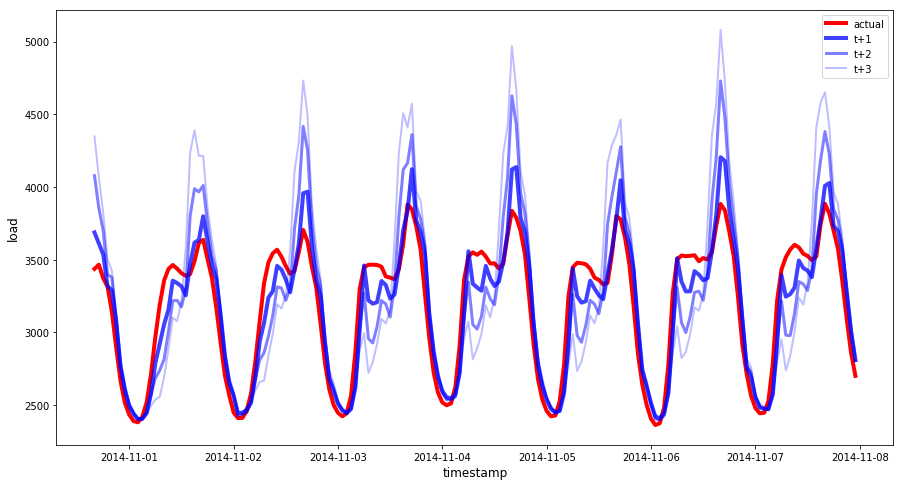

In [58]:
plot_df = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()